# Systrace Parser

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2020-02-05 04:36:06,175 INFO    : root         : Using LISA logging configuration:
2020-02-05 04:36:06,178 INFO    : root         :   /home/ubuntu/Android/lisa_old/logging.conf


In [2]:
%pylab inline

import os
from time import sleep

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

from devlib.utils.android import adb_command

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy
import glob

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

import ipywidgets as widgets
from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Javascript, display

from android import System

import subprocess

from systrace_parser import systrace_parser

2019-11-23 06:04:27,804 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
2019-11-23 06:04:27,818 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


Populating the interactive namespace from numpy and matplotlib


## Test environment setup

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [3]:
import os
os.environ['ANDROID_HOME'] = '/home/ubuntu/Android/AndroidSDK/'

In [4]:
conf = {
    
    # Target platform and board
    "platform"    : 'android',
    "board"       : 'pixel',

    # Device ID
    #"device"      : "HT6670300102",
    
    # Android home
    "ANDROID_HOME" : "/home/ubuntu/Android/AndroidSDK",
    
    # Lisa home
    "LISA_HOME" : "/home/ubuntu/Android/lisa_old",

    # Systrace home
    "SYSTRACE_HOME" : "/ipynb/performance/testingdata",
    
    "MAX_CORE_NUM" : 8
}

## Filters

In [6]:
trace_mark_filters = {
    'launching' : {
        'SMARK' : {'context' : 'launching:', 'type' : 'S'}, 
        'EMARK' : {'context' : 'launching:', 'type' : 'F'},
    },
    'ActivityThreadMain' : {
        'SMARK' : {'context' : 'ActivityThreadMain', 'type' : 'B'}, 
        'EMARK' : {'context' : 'ActivityThreadMain', 'type' : 'E'},
    },
    'bindApplication' : {
        'SMARK' : {'context' : 'bindApplication', 'type' : 'B'}, 
        'EMARK' : {'context' : 'bindApplication', 'type' : 'E'},
    },
    'activityStart' : {
        'SMARK' : {'context' : 'activityStart', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityStart', 'type' : 'E'},
    },
    'activityResume' : {
        'SMARK' : {'context' : 'activityResume', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityResume', 'type' : 'E'},
    },
    'Choreographer' : {
        'SMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'B'}, 
        'EMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'E'},
        'SEPERATE' : [0, 1],
    },
    'setSurface' : {
        'SMARK' : {'context' : 'setSurface', 'type' : 'B'}, 
        'EMARK' : {'context' : 'setSurface', 'type' : 'E'},
    },
}

In [7]:
def MismatchedStringWithoutNumber(comp1, comp2):
    comp1 = unicode(comp1)
    comp2 = unicode(comp2)
    count = 0
    for index in range(min(len(comp1), len(comp2))):
        if comp1[index] != comp2[index] and not comp1[index].isnumeric() and not comp1[index].isnumeric():
            count += 1
            
    return count
#print(MismatchedStringWithoutNumber('A207FSH9_POS_190822_190822_104817_calllog?', 'A207FSH9_POS_190822_180922_104475_calllog1'))

## Select systraces

In [8]:

count = 0
dirname = ''
dirnames = ''
chboxes = list()
chboxes_descriptions = list()

for (path, dir, files) in os.walk(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/'):
    if len(dir) > 0:
        dirnames = dir
    file_groups = list()
    for filename in files:
        if filename.split('.')[-1] == 'html':
            filename = filename[:-5]
            #print(filename)
            new_one = True
            for file_group in file_groups:
                #length_of_file = len(filename)
                #if length_of_file == len(file_group) and filename[:length_of_file/2] == file_group[:length_of_file/2]:
                if not MismatchedStringWithoutNumber(filename, file_group):
                    #print('before  {}'.format(file_groups))
                    #if not file_group.contains('[?]'):
                    #    file_groups.remove(file_group)
                        #file_groups.append('{}?{}'.format(file_group[:-6],file_group[-5:]))
                    #    file_groups.append('{}[?]'.format(file_group[:-3]))
                        #print('after  {}'.format(file_groups))
                    new_one = False
                    break
            if new_one:
                file_groups.append(filename)

    for file_group in file_groups:
        chboxes_descriptions.append('{}{}'.format(dirname, file_group))
    if len(dirnames) > count:
        dirname = dirnames[count] + '/'
    else:
        dirname = ''
    count += 1
    
chboxes_descriptions.sort()
#display(chboxes_descriptions)
for chboxes_description in chboxes_descriptions:
        chboxes.append(widgets.Checkbox(
                value=False,
                description=chboxes_description.decode("utf-8"),
                disabled=False,
                layout=widgets.Layout(width="200%"),
                style={'description_width': 'initial'}
        ))

toggle = widgets.ToggleButton(
    description='START'
)

#chboxes[4].value = True
#chboxes[16].value = True

display(widgets.VBox(chboxes))

VkJveChjaGlsZHJlbj0oQ2hlY2tib3godmFsdWU9RmFsc2UsIGRlc2NyaXB0aW9uPXUnQTAxNUYvQTAxNUZTSzVfUU9TXzE5MTEyMV8xOTExMjFfMTE1MzU4X2hlbGxvd29ybGQnLCBsYXlvdXTigKY=


## Run cells

Please select over two of systrace files and press the run button to execute below cells.
You could see the some graphs of group1 or gruop2 to compare.

In [40]:
def run_all(button):
    #get_ipython().run_cell()
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Run all below")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

Button(description=u'Run all below', style=ButtonStyle())

## Get file list

In [41]:
filelist = list()
title = list()

for chbox in chboxes:
    if chbox.value:
        #print(chbox.description)
        file_path = chbox.description.split('/')
        new_file_path = ''
        if len(file_path) > 1:
            for idx in range(len(file_path) - 1):
                new_file_path += file_path[idx] + '/'
        #length_of_file = len(file_path[-1])
        #new_file_path += file_path[-1][:-3] + '*.html'
        new_file_path += '*.html'
        #print(new_file_path)
        
        gathering_filelist = list()
        for dir_file in glob.glob(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/' + new_file_path):
            if not MismatchedStringWithoutNumber(file_path[-1], dir_file.split('/')[-1]):
                #print(dir_file)
                gathering_filelist.append(dir_file)
        filelist.append(gathering_filelist)
        #filelist[-1].sort()
        title += [file_path[-2] + "_" + file_path[-1]]

if len(filelist) == 0:
    raise  ValueError('Please select some groups of systrace in the over cell.')

Please select two groups of systrace to analysis.

## Read Files

In [42]:
group1 = systrace_parser(trace_mark_filters, filelist[0], title[0])
group2 = systrace_parser(trace_mark_filters, filelist[1], title[1])

In [13]:
group1.run()
group2.run()

Parsing TEST1_POS_191010_191010_192902_contact.html - 178878 lines are Ok
Parsing TEST2TTTT_POS_191010_191010_231835_contact.html - 204101 lines are Ok


## Analysis

### The timing of marking data

The operation times of each trace_mark_filters tags of systrac.

In [14]:
list_of_df = group1.get_marking_time()
print(group1.title)
for df in list_of_df:
    display(df * 1000)

1ZAE_1ZAEFSLC_QOStest_200204_200204_101354_message


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
12192.0,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1410.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,788.533
2436.0,NaN,3.894,2.116,NaN,NaN,NaN,NaN,NaN
1487.0,NaN,0.953,47.251,NaN,NaN,NaN,NaN,NaN
1488.0,NaN,8.092,0.861,NaN,NaN,NaN,NaN,NaN
12593.0,NaN,93.412,8.024,242.151,292.423,31.891,18.717,NaN
12659.0,NaN,NaN,NaN,161.964,NaN,12.054,NaN,NaN
3510.0,1.531,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2490.0,0.347,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
3524.0,2.089,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12360.0,NaN,94.878,6.798,279.620,339.334,19.468,20.343,NaN
11977.0,0.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2508.0,0.324,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2445.0,NaN,1.856,2.010,NaN,NaN,NaN,NaN,NaN
12429.0,NaN,NaN,NaN,194.252,NaN,12.278,NaN,NaN
1448.0,NaN,0.921,39.412,NaN,NaN,NaN,NaN,NaN
1394.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,850.116
12406.0,29.549,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1376.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.456
12352.0,NaN,103.458,7.131,208.008,302.425,16.969,17.321,NaN
1475.0,NaN,1.061,38.457,NaN,NaN,NaN,NaN,NaN
1477.0,NaN,2.592,0.815,NaN,NaN,NaN,NaN,NaN
12394.0,30.739,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2541.0,1.263,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2447.0,NaN,3.519,3.737,NaN,NaN,NaN,NaN,NaN
3474.0,1.446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12419.0,NaN,NaN,NaN,169.547,NaN,14.054,NaN,NaN


In [15]:
list_of_df = group2.get_marking_time()
print(group2.title)
for df in list_of_df:
    display(df * 1000)

1ZAE_1ZAEVTAC_QOStest_200204_200204_105858_message


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
11457.0,NaN,NaN,NaN,416.290,NaN,8.292,NaN,NaN
1383.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,833.575
1448.0,NaN,0.837,24.586,NaN,NaN,NaN,NaN,NaN
1449.0,NaN,2.224,0.555,NaN,NaN,NaN,NaN,NaN
2411.0,0.307,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1932.0,NaN,26.988,6.355,NaN,NaN,NaN,NaN,NaN
3406.0,1.529,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11375.0,NaN,114.338,9.410,338.485,234.195,21.013,21.211,NaN
11438.0,NaN,NaN,NaN,308.919,NaN,17.102,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
11472.0,NaN,NaN,NaN,273.840,NaN,11.948,NaN,NaN
1923.0,NaN,24.611,7.292,NaN,NaN,NaN,NaN,NaN
11493.0,NaN,NaN,NaN,383.587,NaN,8.095,NaN,NaN
2406.0,0.318,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1383.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,802.345
1456.0,NaN,0.975,34.928,NaN,NaN,NaN,NaN,NaN
11409.0,NaN,113.074,8.621,315.847,222.192,18.337,21.114,NaN
2326.0,NaN,4.018,4.030,NaN,NaN,NaN,NaN,NaN
1457.0,NaN,4.633,1.014,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
3398.0,1.433,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11271.0,NaN,NaN,NaN,282.717,NaN,10.678,NaN,NaN
11208.0,NaN,120.933,11.574,359.354,245.181,19.303,23.732,NaN
1930.0,NaN,26.152,12.145,NaN,NaN,NaN,NaN,NaN
1388.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,881.07
2446.0,0.338,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11248.0,32.460,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1461.0,NaN,1.021,30.506,NaN,NaN,NaN,NaN,NaN
1462.0,NaN,2.125,0.527,NaN,NaN,NaN,NaN,NaN


### Launching Time(AVERAGE)

This section is showing the app launching time.

In [46]:
list_of_df = group1.get_marking_time()
count1 = 0

for df in list_of_df:
    get_launching = df[df['launching'] > 0]

    if len(get_launching.index) :
        count1 += 1
        try :
            sum_df1 = pd.concat([sum_df1, get_launching])
        except :
            sum_df1 = get_launching

try :
    sum_df1 = DataFrame(sum_df1.sum(axis=0)).swapaxes("index", "columns") 
    sum_df1.index = [group1.title]
    sum_df1 = sum_df1.replace(0, NaN).dropna(axis=1)
except:
    print("No launching time")

list_of_df = group2.get_marking_time()
count2 = 0

for df in list_of_df:
    get_launching = df[df['launching'] > 0]
    
    if len(get_launching.index) :
        count2 += 1
        try :
            sum_df2 = pd.concat([sum_df2, get_launching])
        except :
            sum_df2 = get_launching

try :
    sum_df2 = DataFrame(sum_df2.sum()).swapaxes("index", "columns") 
    sum_df2.index = [group2.title]
    sum_df2 = sum_df2.replace(0, NaN).dropna(axis=1)

    pd.concat([sum_df1 * 1000 / count1, sum_df2 * 1000 / count2])
except:
    print("No launching time")

/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,launching
G975U_GLPreloading_G975U_P_TEST,487.651
G975U_GLPreloading_G975U_Q_TEST,511.748


### Process Time(AVERAGE)

Process time is from start to end timing within systrace tag of binadApplication / activityStart / ActivityThreadMain / ActivityResume.
 - time : total sum of time of running / runnable / sleeping / uninterruptible sleep.
 - running / runnable / sleeping / uninterruptible sleep : Process stat of cores.
 - setSurface : Just test and check the length of setSurface's tags.
 - launching : Sum of each tags, bindApplication, activityStart, ActivityThreadMain, activityResume, and Choreographer.

In [17]:
df1 = group1.get(systrace_parser.process_state()) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(systrace_parser.process_state()) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

setSurface  \
1ZAE_1ZAEFSLC_QOStest_200204_200204_101354_message time                                0   
                                                   RUNNING                             0   
                                                   RUNNABLE                            0   
                                                   SLEEPING                            0   
                                                   UNINTERUPTIBLE_SLEEP                0   
                                                   UNINTERUPTIBLE_SLEEP(I/O)           0   
1ZAE_1ZAEVTAC_QOStest_200204_200204_105858_message time                                0   
                                                   RUNNING                             0   
                                                   RUNNABLE                            0   
                                                   SLEEPING                            0   
                                                   UNINTERUPTIBLE_SLEEP                0   
                                                   UNINTERUPTIBLE_SLEEP(I/O)           0   
DIFF                                               time                                0   
                                                   RUNNING                             0   
                                                   RUNNABLE                            0   
                                                   SLEEPING                            0   
                                                   UNINTERUPTIBLE_SLEEP                0   
                                                   UNINTERUPTIBLE_SLEEP(I/O)           0   

                                                                              Choreographer #0  \
1ZAE_1ZAEFSLC_QOStest_200204_200204_101354_message time                                 97.249   
                                                   RUNNING                              39.014   
                                                   RUNNABLE                              1.880   
                                                   SLEEPING                             47.866   
                                                   UNINTERUPTIBLE_SLEEP                  0.068   
                                                   UNINTERUPTIBLE_SLEEP(I/O)             8.421   
1ZAE_1ZAEVTAC_QOStest_200204_200204_105858_message time                                116.115   
                                                   RUNNING                              71.998   
                                                   RUNNABLE                              2.111   
                                                   SLEEPING                             38.439   
                                                   UNINTERUPTIBLE_SLEEP                  0.050   
                                                   UNINTERUPTIBLE_SLEEP(I/O)             3.517   
DIFF                                               time                                -18.866   
                                                   RUNNING                             -32.984   
                                                   RUNNABLE                             -0.231   
                                                   SLEEPING                              9.427   
                                                   UNINTERUPTIBLE_SLEEP                  0.018   
                                                   UNINTERUPTIBLE_SLEEP(I/O)             4.904   

                                                                              Choreographer #1  \
1ZAE_1ZAEFSLC_QOStest_200204_200204_101354_message time                                  7.318   
                                                   RUNNING                               1.280   
                                                   RUNNABLE                              0.089   
                                                   SLEEPING               

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
1ZAE_1ZAEFSLC_QOStest_200204_200204_101354_message,time,0,97.249,7.318,243.260,311.394,22.776,18.794,0
1ZAE_1ZAEVTAC_QOStest_200204_200204_105858_message,time,0,116.115,9.868,337.895,233.856,19.551,22.019,0
DIFF,time,0,-18.866,-2.550,-94.635,77.538,3.225,-3.225,0


### Processing time of setSurface

In [18]:
def ProcessingTime(group, index):
    result = dict()
    list_of_df = group.get_marking_time()
    sum = 0
    count = 0
    for df in list_of_df:
        df = df['setSurface'].fillna(0)
        max_value = df.max() * 1000
        sum += max_value
        count += 1
        result[count] = [max_value]
    #print("SUM : {}, AVG : {}".format(sum, sum/count))
    result['avg'] = [sum/count]
    
    df = DataFrame.from_dict(result)
    df.index = [group.title]
    return df

In [19]:
df1 = ProcessingTime(group1, 'setSurface')
df2 = ProcessingTime(group2, 'setSurface')
display(pd.concat([df1, df2]))

,1,2,3,avg
1ZAE_1ZAEFSLC_QOStest_200204_200204_101354_message,27.190,29.549,30.739,29.159333
1ZAE_1ZAEVTAC_QOStest_200204_200204_105858_message,33.136,33.808,32.460,33.134667


### Uninterruptible Sleep

The count of uninterruptible sleep within each tags.

In [50]:
index1 = group1.unint_sleep()
index2 = group2.unint_sleep()
union_index = index1
for index in index2:
    if not index in union_index:
        union_index += [index]

union_index.sort()
        
df1 = group1.get(union_index, func='avg').sort_index()
df1 = df1.dropna(axis=1)

df2 = group2.get(union_index, func='avg').sort_index()
df2 = df2.dropna(axis=1)

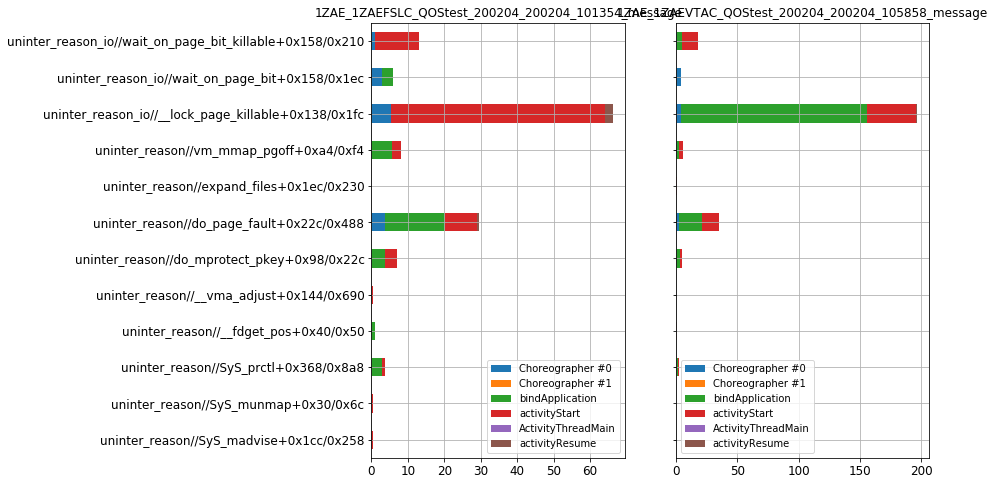

In [21]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharey=True)

df1.plot(kind='barh', ax=axes[0], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group1.title)
df2.plot(kind='barh', ax=axes[1], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group2.title)

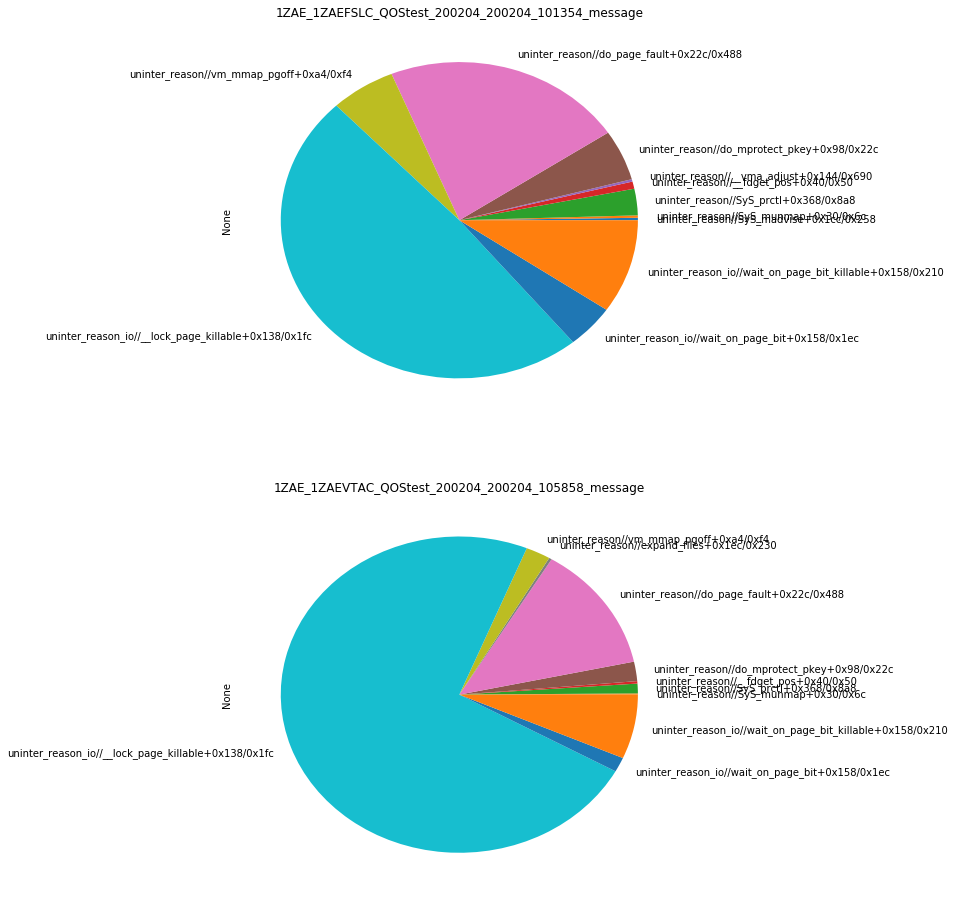

In [22]:
fig,axes = plt.subplots(nrows=2, ncols=1, sharey=True)
df1.sum(axis=1).plot(kind='pie', ax=axes[0], figsize=(8,16), title=group1.title)
df2.sum(axis=1).plot(kind='pie', ax=axes[1], figsize=(8,16), title=group2.title)

The number of count in each reason of uninterruptible sleep.

### Number of Running Cores(SUM)

The number of counting running cores when entering an app.

Choreographer #0  \
TEST_TEST1_POS_191010_191010_192902_contact     core0                 2   
                                                core1                 0   
                                                core2                 1   
                                                core3                 0   
                                                core4                 1   
                                                core5                 1   
                                                core6                14   
                                                core7                20   
TEST_TEST2TTTT_POS_191010_191010_231835_contact core0                 0   
                                                core1                 0   
                                                core2                 1   
                                                core3                 0   
                                                core4                 1   
                                                core5                 0   
                                                core6                 7   
                                                core7                27   

                                                       Choreographer #1  \
TEST_TEST1_POS_191010_191010_192902_contact     core0                 0   
                                                core1                 0   
                                                core2                 0   
                                                core3                 0   
                                                core4                 0   
                                                core5                 0   
                                                core6                 0   
                                                core7                 5   
TEST_TEST2TTTT_POS_191010_191010_231835_contact core0                 0   
                                                core1                 0   
                                                core2                 0   
                                                core3                 0   
                                                core4                 0   
                                                core5                 0   
                                                core6                 0   
                                                core7                 5   

                                                       activityStart  \
TEST_TEST1_POS_191010_191010_192902_contact     core0             29   
                                                core1             21   
                                                core2             17   
                                                core3             15   
                                                core4             23   
                                                core5             31   
                                                core6             62   
                                                core7             81   
TEST_TEST2TTTT_POS_191010_191010_231835_contact core0             19   
                                                core1              9   
                                                core2             14   
                                                core3              8   
                                                core4             25   
                                                core5             21   
                                                core6             47   
                                                core7             94   

                                                       activityResume  
TEST_TEST1_POS_191010_191010_192902_contact     core0               0  
                                                core1               0  
                                                core2         

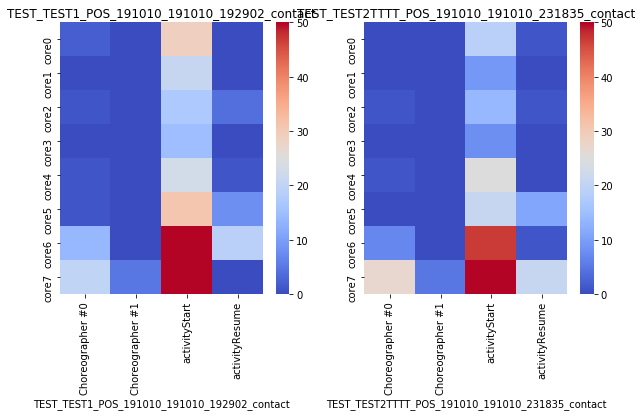

In [23]:
df1 = group1.get(group1.cores(), func='sum')
df1 = df1.dropna(axis=1)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(group2.cores(), func='sum')
df2 = df2.dropna(axis=1)
df2.columns.name = group2.title
#display(df2)
display(pd.concat([df1, df2], keys=[group1.title, group2.title], sort=False))

plt.figure(figsize=(10, 5))
#sb.palplot(sb.color_palette("hls", 8))
subplot(1,2,1, title=group1.title)
sb.heatmap(data=df1, cmap='coolwarm', center=25, vmax = 50);
subplot(1,2,2, title=group2.title)
sb.heatmap(data=df2, cmap='coolwarm', center=25, vmax = 50);

In [24]:
for parser in group1.parsers_of_testing:
    display(parser.get(group1.cores()))

,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,3,0,45,65,0,10,NaN
core1,NaN,10,1,7,61,0,3,NaN
core2,NaN,16,2,35,29,0,10,NaN
core3,NaN,5,0,42,49,4,0,NaN
core4,NaN,0,0,9,2,0,1,NaN
core5,NaN,0,0,8,1,0,0,NaN
core6,NaN,0,0,2,2,0,0,NaN
core7,NaN,0,0,5,0,0,3,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,12,1,30,44,0,7,NaN
core1,NaN,6,0,40,70,1,5,NaN
core2,NaN,10,0,8,44,3,6,NaN
core3,NaN,2,2,25,49,0,11,NaN
core4,NaN,0,0,9,1,0,0,NaN
core5,NaN,0,0,11,1,0,0,NaN
core6,NaN,0,0,4,0,0,0,NaN
core7,NaN,0,0,7,1,0,0,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,9,1,19,57,4,4,NaN
core1,NaN,5,0,27,53,0,5,NaN
core2,NaN,11,0,21,42,0,13,NaN
core3,NaN,3,2,27,47,0,1,NaN
core4,NaN,0,1,5,2,0,0,NaN
core5,NaN,0,0,1,1,0,0,NaN
core6,NaN,0,0,2,1,0,0,NaN
core7,NaN,0,0,1,1,0,0,NaN


In [25]:
for parser in group2.parsers_of_testing:
    display(parser.get(group2.cores()))

,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,3,0,73,47,0,10,NaN
core1,NaN,17,0,65,47,1,4,NaN
core2,NaN,2,6,58,38,2,8,NaN
core3,NaN,9,0,87,51,1,3,NaN
core4,NaN,0,0,4,7,0,0,NaN
core5,NaN,0,0,2,5,0,0,NaN
core6,NaN,0,0,2,5,0,2,NaN
core7,NaN,0,0,2,3,0,0,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,1,3,68,54,1,7,NaN
core1,NaN,3,0,69,33,0,9,NaN
core2,NaN,12,2,80,59,3,4,NaN
core3,NaN,6,0,55,57,0,0,NaN
core4,NaN,0,0,11,6,0,0,NaN
core5,NaN,0,0,5,2,0,0,NaN
core6,NaN,0,0,4,0,0,0,NaN
core7,NaN,0,0,6,3,0,0,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,6,6,65,32,0,9,NaN
core1,NaN,15,0,78,64,0,19,NaN
core2,NaN,12,2,75,44,3,0,NaN
core3,NaN,6,0,70,33,1,9,NaN
core4,NaN,0,0,13,11,0,0,NaN
core5,NaN,0,0,5,8,0,0,NaN
core6,NaN,0,0,2,2,0,0,NaN
core7,NaN,0,0,0,2,0,0,NaN


In [56]:
from systrace_parser import TAG_CORE_IDLE
def GetCoreStats(group):
    for parser in group.parsers_of_testing:
        rawdata = parser.get_rawdata('stat_core')
        index_key_list = list()
        df_list = list()
        
        for index_key in rawdata.keys():
            #print(index_key)
            index_key_list.append(index_key)

            core_state_dict = dict()
            for i in range(8):
                core_state_dict[i] = list()
            core_state_dict['selected'] = list()
            core_state_dict['time'] = list()

            for core_state in rawdata[index_key]:
                for i in range(8):
                    core_state_dict[i].append(core_state.get(i, TAG_CORE_IDLE))
                core_state_dict['selected'].append(core_state.get('selected', -1))
                core_state_dict['time'].append(core_state.get('time', -1))
            #display(DataFrame.from_dict(core_state_dict))
            df_list.append(DataFrame.from_dict(core_state_dict))

    return pd.concat(df_list, keys=index_key_list, sort=False).sort_values(by=['time'])
pd.set_option('display.max_rows', 500)

In [27]:
display(GetCoreStats(group1))

0  1  2  3  4  5  6  7  selected        time
ActivityThreadMain 0    V  I  R  I  I  I  I  I         0  332.536929
                   1    V  I  I  I  I  I  I  I         0  332.537501
                   2    V  I  I  I  I  I  I  I         0  332.545747
                   3    R  I  I  V  I  I  I  I         3  332.551935
bindApplication    0    I  I  R  V  I  I  I  I         3  332.553157
                   1    I  I  V  I  I  I  I  I         2  332.553257
                   2    I  I  R  V  I  I  I  I         3  332.553416
                   3    I  V  I  I  I  I  I  I         1  332.553986
                   4    I  I  I  V  I  I  I  I         3  332.554085
                   5    I  I  I  V  I  I  I  I         3  332.554330
                   6    I  I  I  V  I  I  I  I         3  332.561655
                   7    R  I  I  V  I  I  I  I         3  332.562030
                   8    V  I  I  R  I  I  I  I         0  332.564718
                   9    V  I  I  I  I  I  I  I         0  332.565124
                   10   V  R  I  R  I  I  I  I         0  332.600096
                   11   V  R  I  I  I  I  I  I         0  332.603622
                   12   V  I  R  I  I  I  I  I         0  332.608702
                   13   I  I  V  I  I  I  I  I         2  332.612169
                   14   V  R  I  I  I  I  I  I         0  332.612273
                   15   V  I  I  I  I  I  I  I         0  332.613159
                   16   V  R  I  I  I  I  I  I         0  332.613487
                   17   I  V  I  I  I  I  I  I         1  332.613628
                   18   V  I  I  I  I  I  I  I         0  332.613985
                   19   I  V  I  I  I  I  I  I         1  332.614859
                   20   V  I  I  I  I  I  I  I         0  332.614908
                   21   I  V  R  I  I  I  I  I         1  332.616354
                   22   V  R  I  I  I  I  I  I         0  332.617870
                   23   V  R  I  I  I  I  I  I         0  332.618158
                   24   V  R  I  R  I  I  I  I         0  332.618392
                   25   I  V  I  I  I  I  I  I         1  332.619342
                   26   I  I  I  V  I  I  I  I         3  332.619876
                   27   I  I  I  V  R  I  I  I         3  332.620137
                   28   I  I  I  V  I  I  I  I         3  332.620357
                   29   I  V  I  I  I  I  I  I         1  332.620827
                   30   I  V  I  I  I  I  I  I         1  332.621246
                   31   I  I  I  V  I  I  I  I         3  332.621715
                   32   I  V  I  R  I  I  I  I         1  332.622403
                   33   I  R  V  I  I  I  I  I         2  332.630098
                   34   I  I  V  R  I  I  I  I         2  332.632572
                   35   R  V  I  I  I  I  I  I         1  332.644409
                   36   R  V  I  I  I  I  I  I         1  332.644494
                   37   R  V  I  I  I  I  I  I         1  332.647366
                   38   R  V  I  I  I  I  I  I         1  332.648046
                   39   R  I  V  I  I  I  I  I         2  332.648349
                   40   R  V  I  I  I  I  I  I         1  332.648406
                   41   R  I  V  I  I  I  I  I         2  332.648543
                   42   R  V  I  I  I  I  I  I         1  332.648693
                   43   R  I  V  R  I  I  I  I         2  332.649194
                   44   R  V  R  R  I  I  I  I         1  332.649261
                   45   I  V  I  I  I  I  I  I         1  332.649439
                   46   R  R  I  I  V  I  I  I         4  332.660096
                   47   R  R  V  I  R  I  I  I         2  332.660199
                   48   R  V  I  I  I  I  I  I         1  332.661638
                   49   I  V  I  I  I  I  I  I         1  332.664730
                   50   I  V  I  I  I  I  I  I         1  332.665222
                   51   R  V  I  I  I  I  I  I         1  332.665449
                   52   V  I  R  I  I  I  I  I         0  332.667425
                   53 

In [28]:
display(GetCoreStats(group2))

0  1  2  3  4  5  6  7  selected        time
activityStart    0    I  I  R  I  I  R  V  R         6  326.101650
                 1    I  I  I  R  R  I  R  V         7  326.102389
                 2    I  R  I  I  I  R  R  V         7  326.107365
                 3    I  I  I  I  I  R  R  V         7  326.109628
                 4    I  I  I  I  R  R  R  V         7  326.109651
                 5    I  I  I  R  R  R  R  V         7  326.109670
                 6    I  I  I  I  R  R  R  V         7  326.109690
                 7    I  I  I  I  R  R  R  V         7  326.109704
                 8    I  I  I  R  R  R  R  V         7  326.109721
                 9    I  I  I  R  V  R  R  I         4  326.110187
                 10   I  I  I  I  I  R  R  V         7  326.110327
                 11   I  I  I  I  I  R  R  V         7  326.110366
                 12   I  R  I  V  R  R  R  R         3  326.142804
                 13   R  R  I  V  R  I  I  I         3  326.143306
                 14   I  R  R  I  I  I  I  V         7  326.144121
                 15   R  I  I  R  V  I  R  I         4  326.145858
                 16   I  R  R  R  V  R  R  R         4  326.151692
                 17   I  I  R  I  I  R  V  R         6  326.156521
                 18   I  I  I  R  V  R  I  I         4  326.157549
                 19   I  I  I  I  V  R  I  R         4  326.158737
                 20   R  I  R  I  I  R  I  V         7  326.159870
                 21   R  I  R  R  I  V  R  I         5  326.161572
                 22   I  I  I  I  R  I  I  V         7  326.162670
                 23   I  I  R  I  R  R  I  V         7  326.163616
                 24   I  I  R  I  R  R  R  V         7  326.163672
                 25   I  I  I  R  R  I  V  R         6  326.163999
                 26   I  I  I  I  R  I  V  R         6  326.165015
                 27   I  I  I  R  V  R  R  I         4  326.165482
                 28   I  I  R  I  I  R  I  V         7  326.166013
                 29   I  I  I  I  I  R  I  V         7  326.166802
                 30   I  I  I  I  I  R  V  R         6  326.167221
                 31   R  I  I  R  V  R  I  R         4  326.168094
                 32   I  I  I  R  I  I  V  R         6  326.168154
                 33   R  I  R  R  V  R  I  I         4  326.169439
                 34   R  I  V  I  R  R  I  I         2  326.169878
                 35   I  I  V  R  I  R  I  I         2  326.171148
                 36   I  I  I  R  I  V  R  R         5  326.171628
                 37   I  I  I  I  V  R  R  R         4  326.174725
                 38   R  I  V  R  R  R  I  R         2  326.176100
                 39   R  R  I  I  I  V  R  R         5  326.176701
                 40   I  R  V  R  R  I  I  R         2  326.178383
                 41   I  I  V  I  R  I  I  R         2  326.180153
                 42   I  I  I  R  R  I  I  V         7  326.181484
                 43   I  R  I  I  R  I  V  R         6  326.181992
                 44   R  R  I  R  I  I  R  V         7  326.182448
                 45   I  I  I  I  R  R  R  V         7  326.186699
                 46   I  I  I  I  V  R  R  I         4  326.187427
                 47   R  I  I  R  I  V  R  R         5  326.188358
                 48   I  R  I  I  I  I  V  R         6  326.189385
                 49   I  I  R  I  I  I  I  V         7  326.190044
                 50   I  I  I  I  I  I  R  V         7  326.190200
                 51   I  I  R  I  I  I  I  V         7  326.190934
                 52   R  I  I  I  I  R  I  V         7  326.191431
                 53   I  I  R  R  I  V  R  R         5  326.192400
                 54   I  R  R  I  I  R  V  R         6  326.193527
                 55   I  I  R  R  I  I  R  V         7  326.195304
                 56   I  I  I  R  I  R  V  R         6  326.196666
                 57   I  R  I  I  I  I  I  V         7  326.201307
                 58   I  I  I  I  I  I  V  I         6  326.202174
  

### Cpu Frequency

The graph to show a min lock status of core frequency.

In [59]:
from systrace_parser import CPU_FREQUENCY_LIMITS
def DrawCorrectedData(group, tyep_filter, data_label, func):
    prevalue = dict()
    list_of_df_for_start = group.get_marking_time(dtype='start')
    list_of_df_for_end = group.get_marking_time(dtype='end')
    idx = 0

    for item in group.get(tyep_filter, func='array'):
        df = DataFrame(item, columns=['cpu_id', 'time', data_label])
        df = df.apply(pd.to_numeric)
        
        ### to darw launcging time ++
        min_freq = df[data_label].min()
        prevalue['launching'] = min_freq
        
        if len(list_of_df_for_start) > idx:
            launching_time = list_of_df_for_start[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time, 
                           data_label : ((min_freq + 1) * 2)}, ignore_index=True) 
        if len(list_of_df_for_end) > idx:
            launching_time = list_of_df_for_end[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time,
                           data_label : min_freq}, ignore_index=True)
        ### to darw launcging time --
        
        if func != 0:
            df = func(df)
            
        length = len(df.index)
            
        for i in range(length):
            #display(df.iloc[i])
            if df.iloc[i]['cpu_id'] in prevalue.keys():
                df = df.append({'cpu_id' : df.iloc[i]['cpu_id'], 
                           'time' : (df.iloc[i]['time'] - 0.000001), 
                           data_label : prevalue[df.iloc[i]['cpu_id']]}, ignore_index=True) 
                #display(df.iloc[i])
            prevalue[df.iloc[i]['cpu_id']] = df.iloc[i][data_label]
        
        idx += 1
        df.index = df['time']
        df = df.sort_index()
        df.groupby(['cpu_id'])[data_label].plot(legend=True, figsize=(15,4))
        plt.show()

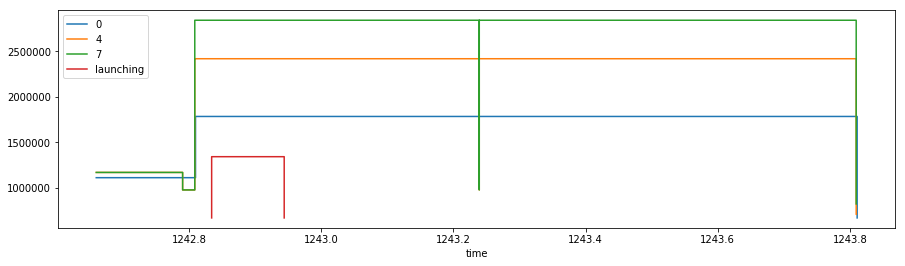

In [60]:
DrawCorrectedData(group1, CPU_FREQUENCY_LIMITS, 'min', 0)

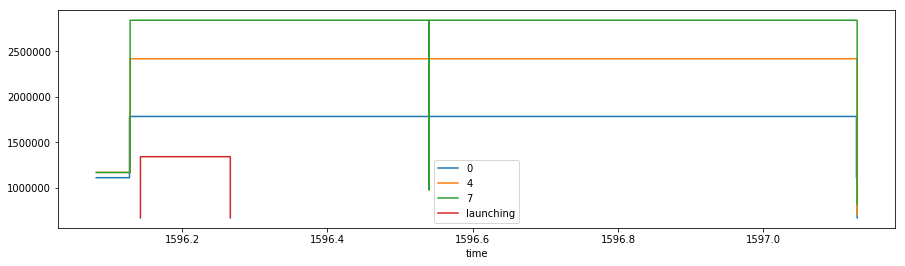

In [61]:
DrawCorrectedData(group2, CPU_FREQUENCY_LIMITS, 'min', 0)

### Cpu Idle

The graph to show a min lock status of core Idle.

In [62]:
from systrace_parser import CPU_IDLE
def PreprocessingForCPUIDLE(df):
    try :
        df_launching = df[df.cpu_id == 'launching']
    except :
        df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

        df.loc[df.state >= 4294967295, 'state'] = -1
        df['state'] = df['state'] + 1
        
        return df

    df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

    df.loc[df.state >= 4294967295, 'state'] = -1
    df['state'] = df['state'] + 1
    
    df = df[df.time >= (df_launching['time'].iloc[0] - 0.1)]
    df = df[df.time <= (df_launching['time'].iloc[1] + 0.1)]
    
    df = pd.concat([df, df_launching])
    return df

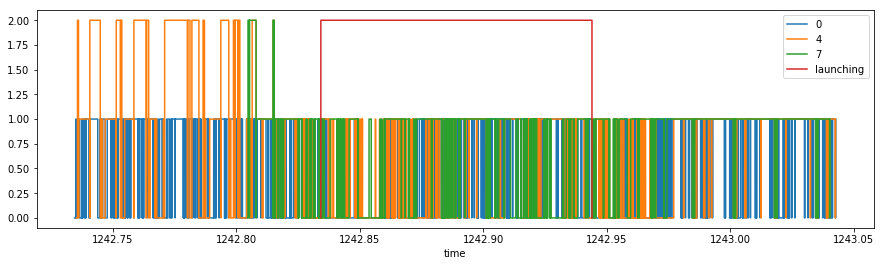

In [63]:
DrawCorrectedData(group1, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

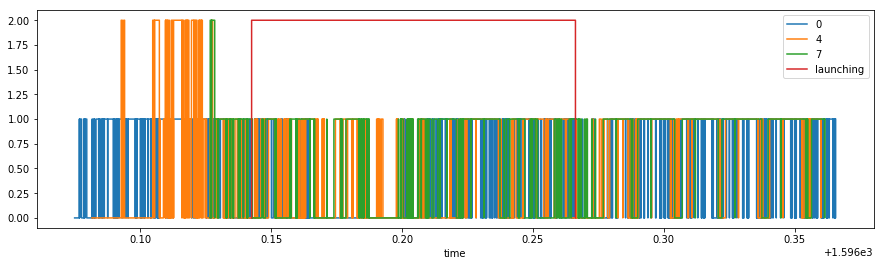

In [64]:
DrawCorrectedData(group2, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

### Lock Contention

In [65]:
df1 = group1.get(['lock_contention']) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(['lock_contention']) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
#display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
G975U_GLPreloading_G975U_P_TEST,lock_contention,0,5.718,4.513,0.000,17.459,0.000,0,0
G975U_GLPreloading_G975U_Q_TEST,lock_contention,0,4.515,0.000,0.453,17.626,16.297,0,0
DIFF,lock_contention,0,1.203,4.513,-0.453,-0.167,-16.297,0,0


In [66]:
def DrawLockContention(parser):
    for lock_contention in parser.storage_lock_contention:
        lock_contention['owner'] = lock_contention['context'].split('owner ')[1].split(' waiters')[0]
        lock_contention['blocking'] = lock_contention['context'].split('blocking from')[1]
    df = DataFrame.from_dict(parser.storage_lock_contention)
    df.loc[df['duration'] > 0, 'duration'] *= 1000

    return df
        #if value == 'NaN':
            
        #else:
        #    display(DataFrame(df[value].value_counts()))

Liminated the lock contentions by the main thread is sleepping in an app.
(The effection means that lock contentions seem to effect to the app entry because the process stat was sleep.)

In [67]:
#for parser in group.parsers_of_testing:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df1 = df[df['effection'] == 'O']
display(group1.title)
display(df1.sort_values(by=['duration'], ascending=False))

u'G975U_GLPreloading_G975U_P_TEST'

,blocking,context,duration,effection,owner,pid,time,type
42,java.util.List com.android.server.am.Activity...,monitor contention with owner Binder:1194_19 (...,10.272,O,Binder:1194_19 (8538) at void com.android.serv...,3120,1242.859919,B
117,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1194_12 (...,5.408,O,Binder:1194_12 (3542) at int com.android.serve...,1358,1243.254638,B
25,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (16...,5.008,O,android.anim (1604) at int com.android.server....,3542,1242.835718,B
32,int com.android.server.am.ActivityManagerServ...,monitor contention with owner Binder:1194_12 (...,4.648,O,Binder:1194_12 (3542) at void com.android.serv...,8538,1242.845203,B
54,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1194_9 (2...,3.439,O,Binder:1194_9 (2124) at int com.android.server...,1358,1242.904929,B
26,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (16...,3.368,O,android.anim (1604) at int com.android.server....,1358,1242.837430,B
44,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (16...,2.703,O,android.anim (1604) at void com.android.server...,3542,1242.867249,B
115,void com.android.server.wm.WindowSurfacePlace...,monitor contention with owner Binder:1194_12 (...,2.583,O,Binder:1194_12 (3542) at int com.android.serve...,1604,1243.253070,B
116,int com.android.server.wm.WindowManagerServic...,monitor contention with owner Binder:1194_12 (...,2.468,O,Binder:1194_12 (3542) at int com.android.serve...,8538,1243.253929,B
33,int com.android.server.am.MultiWindowManagerS...,monitor contention with owner Binder:1194_12 (...,1.900,O,Binder:1194_12 (3542) at void com.android.serv...,2124,1242.847833,B


In [68]:
#for parser in group.parsers_of_testing:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df2 = df[df['effection'] == 'O']
display(group2.title)
display(df2.sort_values(by=['duration'], ascending=False))

u'G975U_GLPreloading_G975U_Q_TEST'

,blocking,context,duration,effection,owner,pid,time,type
28,int com.android.server.am.ActivityManagerServ...,monitor contention with owner Binder:992_3 (50...,8.100,O,Binder:992_3 (5057) at void com.android.server...,5452,1596.143617,B
34,void com.android.server.am.ActivityManagerSer...,monitor contention with owner Binder:992_3 (50...,7.290,O,Binder:992_3 (5057) at void com.android.server...,1143,1596.144609,B
19,void com.android.server.wm.WindowAnimator.lam...,monitor contention with owner Binder:992_A (54...,5.164,O,Binder:992_A (5452) at int com.android.server....,1147,1596.137568,B
20,void com.android.server.wm.TaskChangeNotifica...,monitor contention with owner Binder:992_A (54...,4.704,O,Binder:992_A (5452) at int com.android.server....,1143,1596.138094,B
46,boolean com.android.server.wm.WindowProcessCo...,monitor contention with owner android.anim (11...,3.882,O,android.anim (1147) at int com.android.server....,5452,1596.155550,B
51,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:992_3 (50...,3.349,O,Binder:992_3 (5057) at void com.android.server...,1147,1596.166558,B
152,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:992_12 (7...,3.308,O,Binder:992_12 (7471) at int com.android.server...,1143,1596.557373,B
118,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:992_A (54...,3.302,O,Binder:992_A (5452) at int com.android.server....,1143,1596.241167,B
47,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (11...,3.158,O,android.anim (1147) at int com.android.server....,1143,1596.156337,B
52,android.app.ActivityManager$StackInfo com.and...,monitor contention with owner Binder:992_3 (50...,3.137,O,Binder:992_3 (5057) at void com.android.server...,1143,1596.166887,B


Sum of the lock contention's duration. The durations could be duplicated.

In [69]:
display(group1.title)
display(df1['duration'].sum())

u'G975U_GLPreloading_G975U_P_TEST'

51.4119999995728

In [70]:
display(group2.title)
display(df2['duration'].sum())

u'G975U_GLPreloading_G975U_Q_TEST'

87.24799999959032

Liminated the lock contentions by owners.

In [71]:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group1.title)
display(DataFrame(df['owner'].value_counts()))

u'G975U_GLPreloading_G975U_P_TEST'

,owner
android.anim (1604) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:153),4
"Binder:1194_12 (3542) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.Surface, android.graphics.PointF, com.samsung.android.view.ConventionalModeBar$Info)(WindowManagerService.java:2217)",3
"Binder:1194_19 (8538) at void com.android.server.am.ActivityManagerService.setTaskDescription(android.os.IBinder, android.app.ActivityManager$TaskDescription)(ActivityManagerService.java:13842)",2
"Binder:1194_9 (2124) at java.util.List com.android.server.am.ActivityManagerService.getFilteredTasks(int, int, int)(ActivityManagerService.java:13683)",2
"android.anim (1604) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.Surface, android.graphics.PointF, com.samsung.android.view.ConventionalModeBar$Info)(WindowManagerService.java:2217)",2
Binder:1194_19 (8538) at android.app.ActivityManager$StackInfo com.android.server.am.ActivityManagerService.getFocusedStackInfo()(ActivityManagerService.java:26903),2
Binder:1194_12 (3542) at void com.android.server.am.ActivityManagerService.activityPaused(android.os.IBinder)(ActivityManagerService.java:10410),2
"Binder:1194_9 (2124) at boolean android.os.MessageQueue.enqueueMessage(android.os.Message, long)(MessageQueue.java:544)",1
"Binder:1194_F (3120) at void com.android.server.InputMethodManagerService.onSessionCreated(com.android.internal.view.IInputMethod, com.android.internal.view.IInputMethodSession, android.view.InputChannel)(InputMethodManagerService.java:3119)",1
"ActivityManager (1308) at void com.android.server.am.TaskChangeNotificationController.forAllRemoteListeners(com.android.server.am.TaskChangeNotificationController$TaskStackConsumer, android.os.Message)(TaskChangeNotificationController.java:246)",1


In [72]:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group2.title)
display(DataFrame(df['owner'].value_counts()))

u'G975U_GLPreloading_G975U_Q_TEST'

,owner
android.anim (1147) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:141),8
android.display (1143) at int com.android.server.wm.MultiTaskingManager.getMultiWindowModeStates(int)(MultiTaskingManager.java:568),4
"android.ui (1130) at java.util.List com.android.server.wm.ActivityTaskManagerService.getFilteredTasks(int, int, int)(ActivityTaskManagerService.java:3231)",4
android.anim (1147) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:132),4
android.anim (1147) at void com.android.server.wm.WindowSurfacePlacer.lambda$new$0$WindowSurfacePlacer()(WindowSurfacePlacer.java:65),3
"Binder:992_12 (7471) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2194)",3
"Binder:992_3 (5057) at void com.android.server.am.ActivityManagerService.attachApplication(android.app.IApplicationThread, long)(ActivityManagerService.java:5941)",3
android.display (1143) at void com.android.server.wm.WindowManagerService$H.handleMessage(android.os.Message)(WindowManagerService.java:5248),2
"android.display (1143) at java.util.List com.android.server.pm.PackageManagerService.queryIntentActivitiesInternal(android.content.Intent, java.lang.String, int, int, int, boolean, boolean)(PackageManagerService.java:8542)",2
"android.display (1143) at void com.android.server.wm.ActivityMetricsLogger.checkVisibility(com.android.server.wm.TaskRecord, com.android.server.wm.ActivityRecord)(ActivityMetricsLogger.java:575)",2


Text(0,0.5,'weight')

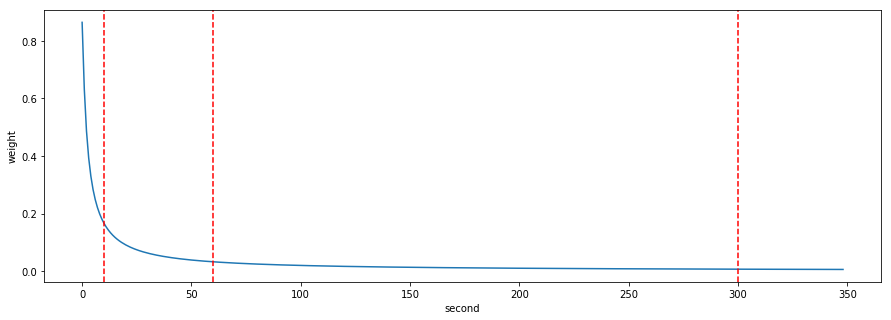

In [73]:
from math import exp


#display(np.exp(-2.0/np.arange(1,300.0)) * 2048)
plt.figure(figsize=(15,5))
plt.plot(1 - np.exp(-2.0/np.arange(1,350.0)))
plt.axvline(x=10, color='r', linestyle='--')
plt.axvline(x=60, color='r', linestyle='--')
plt.axvline(x=300, color='r', linestyle='--')
plt.xlabel('second')
plt.ylabel('weight')